Changing the Keras backend from TensorFlow to PlaidML

In [2]:
import os

os.environ["RUNFILES_DIR"] = "/Users/shreyasm/opt/anaconda3/share/plaidml"
os.environ["PLAIDML_NATIVE_PATH"] = "/Users/shreyasm/opt/anaconda3/lib/libplaidml.dylib"
os.environ["KERAS_BACKEND"] = "plaidml.keras.backend"

Importing libraries (Remember to import Keras using "import keras" and not "import tensorflow.keras")

In [123]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import load_model
import h5py as hp
import numpy as np
import matplotlib.pyplot as plt

Setting the hyperparameters

In [4]:

batch_size = 256
num_classes = 10
epochs = 20

Set image dimensions

In [5]:
img_rows, img_cols = 28, 28

Loading the datasets

In [6]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

Viewing the images in the dataset

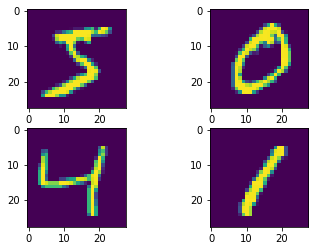

(28, 28)


In [7]:
im, arr = plt.subplots(2,2)
arr[0,0].imshow(x_train[0])
arr[0,1].imshow(x_train[1])
arr[1,0].imshow(x_train[2])
arr[1,1].imshow(x_train[3])
plt.show()
print(x_train[0].shape)

Reshaping our data and normalising the pixel values to range between 0 to 255

In [8]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

These are number of images in our training and test dataset

In [9]:
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


Converting the classes to categorical data

In [10]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Calling the model and adding layers to the Neural Network, then configuring it for training (model.compile)

In [11]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=0.001),
              metrics=['accuracy'])

INFO:plaidml:Opening device "metal_amd_radeon_pro_5300m.0"


How our model looks:

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

Training the model

In [13]:
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test),
          shuffle=False)

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
60000/60000 [==============================] - 27s 457us/step - loss: 0.3342 - acc: 0.8996 - val_loss: 0.0638 - val_acc: 0.9799
Epoch 2/20
60000/60000 [==============================] - 23s 375us/step - loss: 0.1017 - acc: 0.9702 - val_loss: 0.0475 - val_acc: 0.9843
Epoch 3/20
60000/60000 [==============================] - 23s 376us/step - loss: 0.0753 - acc: 0.9776 - val_loss: 0.0389 - val_acc: 0.9874
Epoch 4/20
60000/60000 [==============================] - 23s 378us/step - loss: 0.0607 - acc: 0.9814 - val_loss: 0.0339 - val_acc: 0.9887
Epoch 5/20
60000/60000 [==============================] - 23s 376us/step - loss: 0.0518 - acc: 0.9841 - val_loss: 0.0340 - val_acc: 0.9891
Epoch 6/20
60000/60000 [==============================] - 23s 377us/step - loss: 0.0444 - acc: 0.9860 - val_loss: 0.0336 - val_acc: 0.9889
Epoch 7/20
60000/60000 [==============================] - 23s 381us/step - loss: 0.0379 - acc: 0.9880 - val_loss: 0.

Save the model

In [122]:
model.save('/Users/shreyasm/Downloads/Python_progs/KerasOpenCL/trained_model.h5')

trained_model = hp.File('/Users/shreyasm/Downloads/Python_progs/KerasOpenCL/trained_model.h5')
print("The following are the weights of the model: ")
trained_model_weights = list(trained_model['model_weights']['dense_2']['dense_2']['kernel'])
print(trained_model_weights)

The following are the weights of the model: 
[array([-0.18528037, -0.03450375, -0.09723603, -0.13521016,  0.01945516,
       -0.26624718, -0.12445081,  0.2268593 , -0.19691941, -0.0931255 ],
      dtype=float32), array([ 0.07898563, -0.11190557, -0.06129547,  0.16504237,  0.07354669,
       -0.0075501 ,  0.03221561,  0.00198099,  0.15792885, -0.07870314],
      dtype=float32), array([-0.29648685,  0.12756024,  0.13394564,  0.13024026,  0.16593547,
        0.16079913, -0.24519484, -0.14683717,  0.00670113,  0.15952852],
      dtype=float32), array([-0.29660738,  0.15314806, -0.1274161 , -0.17404008, -0.24270639,
        0.19079085, -0.11655663, -0.17430648, -0.15590987,  0.14997955],
      dtype=float32), array([ 0.1742696 ,  0.01768243, -0.15756142, -0.16768475, -0.01207889,
        0.06729177, -0.03977962,  0.10898471,  0.06703407, -0.14882943],
      dtype=float32), array([ 1.8532762e-01, -3.2689956e-01,  9.4490744e-02,  1.9568418e-01,
       -2.0522244e-01,  1.6344650e-04,  1.873388

Evaluating the performance of the model using accuracy metrics and plotting the loss over iterations

Test loss: 0.03380306740999222
Test accuracy: 0.9905


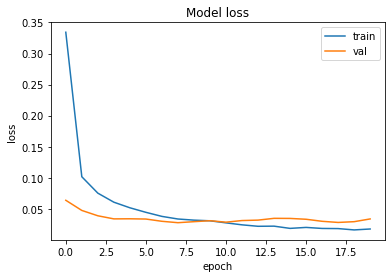

In [124]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

The image to be predicted is

Image of the digit: 


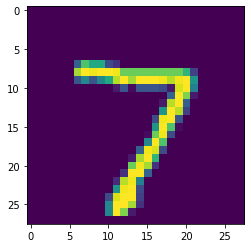

In [128]:
def load_image(filename):
    img = load_img(filename, color_mode='grayscale', target_size=(28, 28))
    img = img_to_array(img)
    img = img.reshape(1, 28, 28, 1)
    img = img.astype('float32')
    img = img / 255
    return img

def run_example(filename):
    predict_val = model.predict(img)
    digit = np.argmax(predict_val)
    print("The predicted digit from the image is:", digit)

#replace 'three.jpeg with the path to your own image
img = load_image('MNIST_sample_image.png')
print("Image of the digit: ")
plt.imshow(img.reshape(28,28))
plt.show()



Predicting the displayed digit

In [129]:
run_example(img)

The predicted digit from the image is: 7
